In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX
import os 

# Auxiliary Functions

In [2]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_new import vit_base_patch16_224 
from baselines.ViT.ViT_orig_LRP import vit_base_patch16_224 as vit_orig_LRP
from baselines.ViT.ViT_explanation_generator import LRP,IBA,Baselines

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = IBA(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="IBA", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Top 5 classes:
	207 : golden retriever  		value = 9.716	 prob = 66.7%
	285 : Egyptian cat      		value = 7.722	 prob = 9.1%
	208 : Labrador retriever		value = 7.636	 prob = 8.3%
	281 : tabby, tabby cat  		value = 6.470	 prob = 2.6%
	222 : kuvasz            		value = 6.249	 prob = 2.1%


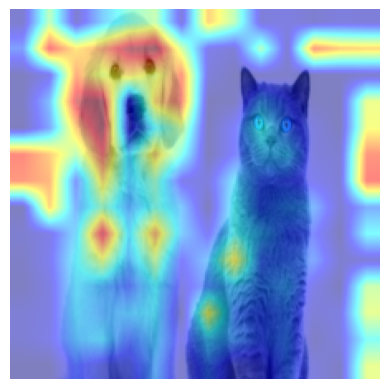

In [3]:
image = Image.open('samples/dogcat2.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs.imshow(image);
# axs.axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# golden retriever - the predicted class
dog = generate_visualization(dog_cat_image)

# generate visualization for class 285: 'Egyptian cat'
cat = generate_visualization(dog_cat_image, class_index=285)


# axs.imshow(cat);
axs.imshow(dog);
axs.axis('off');